# Noise robustness exploratory plots

Quick plots to visualize how accuracy changes with noise level (`sigma`) across arms (NL, code, sim, controlsim) and noise types (gaussian/uniform). Update `DATA_DIR` or `FILES` below if your results are elsewhere.

In [36]:
import json
from pathlib import Path

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")


In [37]:
# Configure paths (search a few likely locations)
CANDIDATE_DIRS = [
    Path("../results_noise"),
]
FILES = []
for d in CANDIDATE_DIRS:
    if d.exists():
        FILES.extend(list(d.glob("*.json")))
FILES = sorted(set(FILES))  # de-duplicate
print("Found", len(FILES), "files")

Found 1 files


In [38]:
def load_noise_results(files):
    rows = []
    summaries = []
    for fp in files:
        payload = json.loads(fp.read_text())
        if not payload:
            continue
        *records, summary = payload
        if records:
            df = pd.DataFrame.from_records(records)
            df["source"] = fp.name
            rows.append(df)
        summaries.append(summary)
    data = pd.concat(rows, ignore_index=True) if rows else pd.DataFrame()
    meta = pd.DataFrame.from_records(summaries) if summaries else pd.DataFrame()
    return data, meta

if not FILES:
    print("No noise result files found. Update CANDIDATE_DIRS or generate via noise_runner/noise.sh.")

data, meta = load_noise_results(FILES)
print(data.head())
print(meta.tail(1))

  kind  accuracy  arm noise_type  sigma  \
0  add      1.00   nl   gaussian    0.0   
1  lcs      1.00   nl   gaussian    0.0   
2  mul      0.75   nl   gaussian    0.0   
3  sub      1.00   nl   gaussian    0.0   
4  add      1.00  sim   gaussian    0.0   

                                              source  
0  anthropic-claude-haiku-4.5_seed1_noise_2026010...  
1  anthropic-claude-haiku-4.5_seed1_noise_2026010...  
2  anthropic-claude-haiku-4.5_seed1_noise_2026010...  
3  anthropic-claude-haiku-4.5_seed1_noise_2026010...  
4  anthropic-claude-haiku-4.5_seed1_noise_2026010...  
                        model     backend  seed          noise_types  \
0  anthropic/claude-haiku-4.5  openrouter     1  [gaussian, uniform]   

                  noise_levels                 kinds digits_list  n  \
0  [0.0, 0.25, 0.5, 0.75, 1.0]  [add, sub, mul, lcs]      [2, 4]  4   

                    timestamp  \
0  2026-01-07T23:17:24.927180   

                                                path  
0

In [39]:
# Basic cleaning/casting
if not data.empty:
    data["sigma"] = data["sigma"].astype(float)
    data["accuracy"] = data["accuracy"].astype(float)
    data["noise_type"] = data["noise_type"].astype(str)
    data["arm"] = data["arm"].astype(str)
    data["kind"] = data["kind"].astype(str)

meta

,model,backend,seed,noise_types,noise_levels,kinds,digits_list,n,timestamp,path
0,anthropic/claude-haiku-4.5,openrouter,1,"[gaussian, uniform]","[0.0, 0.25, 0.5, 0.75, 1.0]","[add, sub, mul, lcs]","[2, 4]",4,2026-01-07T23:17:24.927180,src/exps_performance/results_noise/anthropic-c...


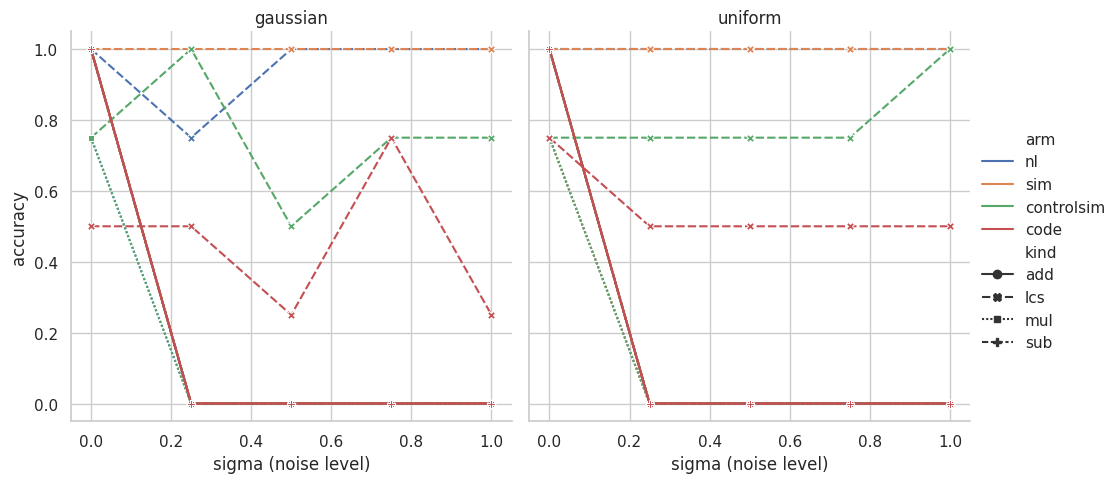

In [40]:
# Plot accuracy vs sigma by arm, faceted by noise type
if not data.empty:
    g = sns.relplot(
        data=data,
        x="sigma",
        y="accuracy",
        hue="arm",
        style="kind",
        col="noise_type",
        kind="line",
        markers=True,
        facet_kws={"sharey": True, "sharex": True},
    )
    g.set_titles("{col_name}")
    g.set_axis_labels("sigma (noise level)", "accuracy")
    plt.show()


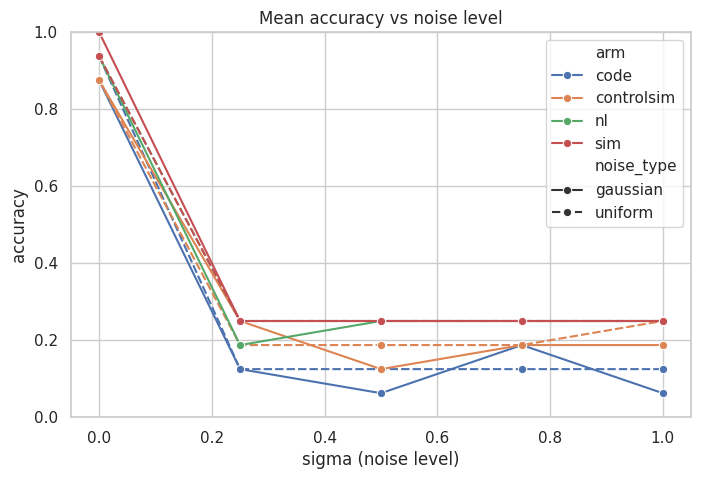

In [41]:
# Aggregate mean accuracy by arm/noise_type across kinds
if not data.empty:
    agg = (
        data.groupby(["noise_type", "sigma", "arm"], as_index=False)["accuracy"].mean()
    )
    plt.figure(figsize=(8, 5))
    sns.lineplot(data=agg, x="sigma", y="accuracy", hue="arm", style="noise_type", marker="o")
    plt.title("Mean accuracy vs noise level")
    plt.xlabel("sigma (noise level)")
    plt.ylabel("accuracy")
    plt.ylim(0, 1)
    plt.show()


## How to use
1) Generate noise results (JSON) via `src/exps_performance/scripts/noise.sh` or directly running `python -m src.exps_performance.noise_runner ...`.
2) Place outputs under `src/exps_performance/results_noise/` (default) or update `DATA_DIR` above.
3) Run cells to visualize accuracy vs noise for NL / code / sim / controlsim, faceted by noise type.